# LSTM Stock Forecasting

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf # Library for downloading stock data

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler # For scaling data
from sklearn.metrics import mean_squared_error # For calculating RMSE

from torch.utils.data import Dataset, DataLoader # PyTorch utilities for handling data

from copy import deepcopy as dc # For deep copying dataframes/arrays

import itertools # For generating hyperparameter combinations
import math # For sqrt in RMSE

print("Libraries imported.")

Libraries imported.


## 2. Data Loading


In [2]:
ticker = input("Enter the stock ticker: ") # Get ticker symbol
ticker = ticker.upper()

data = yf.download(ticker, period = "max") # Download historical data using yfinance

display(data)

Enter the stock ticker: NKE
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NKE,NKE,NKE,NKE,NKE
Date,,,,,
1980-12-02,0.125838,0.128573,0.125838,0.125838,100710400
1980-12-03,0.123102,0.124469,0.123102,0.124469,25177600
1980-12-04,0.127206,0.128573,0.127206,0.127206,22694400
1980-12-05,0.120366,0.123102,0.120366,0.123102,7590400
1980-12-08,0.113527,0.114895,0.113527,0.114895,5414400
...,...,...,...,...,...
2025-04-21,56.119999,56.360001,53.500000,55.230000,17280900
2025-04-22,57.060001,58.090000,56.240002,56.650002,16852200


## 3. Preprocessing

In [3]:
data = data[['Close']] # Keep only the 'Close' price column
data = data.reset_index() # Make the 'Date' index a regular column
data = data[['Date', 'Close']] # Ensure correct column order

display(data)

Price,Date,Close
Ticker,,NKE
0,1980-12-02,0.125838
1,1980-12-03,0.123102
2,1980-12-04,0.127206
3,1980-12-05,0.120366
4,1980-12-08,0.113527
...,...,...
11186,2025-04-21,56.119999
11187,2025-04-22,57.060001
11188,2025-04-23,57.389999


## 4. Plotting Raw Data

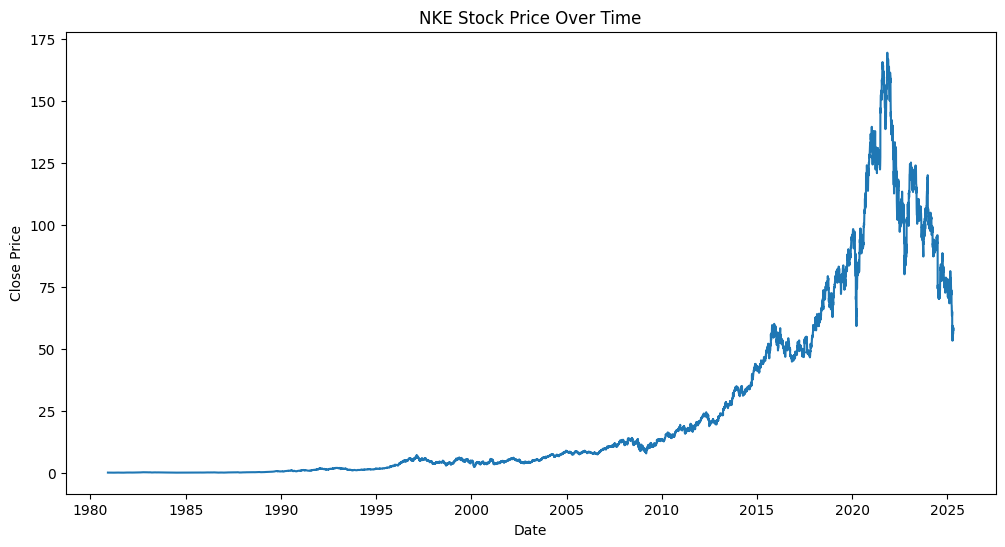

In [4]:
# Ensure 'Date' column is in datetime format for plotting
data['Date'] = pd.to_datetime(data['Date'])

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'{ticker} Stock Price Over Time')
plt.show()

## 5. Feature Engineering (Lagging Function)

In [5]:
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df) # Use deepcopy to avoid modifying original dataframe

  # Set 'Date' as index for easy shifting
  df.set_index('Date', inplace=True)

  # Create lagged features
  for i in range(1, n_steps + 1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  # Remove rows with NaN values created by shifting
  df.dropna(inplace=True)

  return df

# Define the lookback period (how many previous days to use as input features)
lookback = 7

shifted_df = prepare_dataframe_for_lstm(data, lookback)

display(shifted_df.tail())

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Ticker,NKE,,,,,,,
Date,,,,,,,,
2025-04-21,56.119999,55.759998,53.549999,54.830002,55.410000,54.389999,54.400002,59.320000
2025-04-22,57.060001,56.119999,55.759998,53.549999,54.830002,55.410000,54.389999,54.400002
2025-04-23,57.389999,57.060001,56.119999,55.759998,53.549999,54.830002,55.410000,54.389999
2025-04-24,58.480000,57.389999,57.060001,56.119999,55.759998,53.549999,54.830002,55.410000
2025-04-25,57.619999,58.480000,57.389999,57.060001,56.119999,55.759998,53.549999,54.830002


## 6. Data Scaling

In [6]:
# Convert DataFrame to NumPy array for scaling
shifted_df_as_np = shifted_df.to_numpy()

# Initialize scaler to scale features between -1 and 1 (common for LSTMs)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data and transform it
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

## 7. Create Features X and Target y

In [7]:
# Target (y) is the 'Close' price we want to predict (first column of scaled array)
y = shifted_df_as_np[:, 0]

# Features (X) are the lagged 'Close(t-1)' to 'Close(t-n)' prices (remaining columns)
X = shifted_df_as_np[:, 1:]

# Reverse the order of lagged features so X becomes [Close(t-n), ..., Close(t-1)]
X = dc(np.flip(X, axis=1))

## 8. Train/Test Split

In [8]:
# Define the split point (95% train, 5% test)
split_index = int(len(X) * 0.95)

# Split features
X_train = X[:split_index]
X_test = X[split_index:]

# Split target
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training set size: X={X_train.shape}, y={y_train.shape}")
print(f"Test set size: X={X_test.shape}, y={y_test.shape}")

Training set size: X=(10624, 7), y=(10624,)
Test set size: X=(560, 7), y=(560,)


## 9. Reshape Data for LSTM and Convert to Tensors

In [9]:
# Reshape X arrays: add a third dimension for the single feature ('Close' price)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

# Reshape y arrays: make them column vectors (required by loss function)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Convert NumPy arrays to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

## 10. Define Pytorch Dataset Class

In [10]:
# Custom Dataset class to handle time series data for DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        # Returns the total number of samples
        return len(self.X)

    def __getitem__(self, i):
        # Returns the i-th sample (feature sequence and target)
        return self.X[i], self.y[i]

# Create Dataset instances
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

## 11. Create DataLoaders

In [11]:
batch_size = 16 # Set batch size for training and testing

# Training DataLoader - shuffles data each epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Test DataLoader - no need to shuffle for evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 12. Define LSTM Model Class

In [12]:
# Ensure device is defined ('cuda:0' or 'cpu')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_prob=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True,
                            dropout=dropout_prob if num_stacked_layers > 1 else 0)

        # Define a Dropout layer to apply after LSTM output, before the final linear layer
        self.dropout = nn.Dropout(dropout_prob)
        # Define the final fully connected layer to output a single prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        batch_size = x.size(0)
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Pass input sequence through LSTM
        # out shape: (batch_size, sequence_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # Apply dropout to this output
        out = self.dropout(out[:, -1, :])
        # Pass the result through the final linear layer
        out = self.fc(out)
        # Final out shape: (batch_size, 1)
        return out


Using device: cpu


## 13. Defining train_one_epoch() and valdiate_one_epoch()

In [13]:
def train_one_epoch():
    model.train(True) # Set model to training mode
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [14]:
def validate_one_epoch():
    model.train(False) # Set model to evaluation mode
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): # Disable gradient calculations
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    # Calculate average loss over all validation batches
    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

## 14. Grid Search for Hyperparameter Tuning

In [15]:
# Define Hyperparameter Grid
param_grid = {
    'hidden_size': [4, 8, 16],
    'num_stacked_layers': [1, 2],
    'learning_rate': [0.01, 0.001],
    'dropout_prob': [0.0, 0.2]
}
num_search_epochs = 5

# Setup for Grid Search
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Testing {len(hyperparameter_combinations)} combinations over {num_search_epochs} epochs each...")

results = []
best_val_loss = float('inf')
best_params = None

# Grid Search Loop
for i, params in enumerate(hyperparameter_combinations):
    print(f"\n--- Combination {i+1}/{len(hyperparameter_combinations)}: {params} ---")

    # Setup Model & Optimizer for this combination
    current_model = LSTM(input_size=1,
                         hidden_size=params['hidden_size'],
                         num_stacked_layers=params['num_stacked_layers'],
                         dropout_prob=params['dropout_prob'])
    current_model.to(device)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(current_model.parameters(), lr=params['learning_rate'])

    current_run_best_val_loss = float('inf')

    # Training & Validation Loop for this combination
    for epoch in range(num_search_epochs):
        # Training Phase
        current_model.train()
        train_loss_epoch = 0
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = current_model(x_batch)
            loss = loss_function(output, y_batch)
            train_loss_epoch += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_train_loss = train_loss_epoch / len(train_loader)

        # Validation Phase
        current_model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_index, batch in enumerate(test_loader):
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = current_model(x_batch)
                loss = loss_function(output, y_batch)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(test_loader)

        current_run_best_val_loss = min(current_run_best_val_loss, avg_val_loss)

    print(f"Finished testing {params}. Best Val Loss for this run: {current_run_best_val_loss:.5f}")

    # Store results and track overall best
    results.append({'params': params, 'val_loss': current_run_best_val_loss})
    if current_run_best_val_loss < best_val_loss:
        best_val_loss = current_run_best_val_loss
        best_params = params

# End Grid Search Loop

print("=" * 50)
print(f"Grid Search Complete.")
print(f"Best Validation Loss achieved: {best_val_loss:.5f}")
print(f"Best Parameters found: {best_params}")
print("=" * 50)

Testing 24 combinations over 5 epochs each...

--- Combination 1/24: {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.01, 'dropout_prob': 0.0} ---
Finished testing {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.01, 'dropout_prob': 0.0}. Best Val Loss for this run: 0.00059

--- Combination 2/24: {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.01, 'dropout_prob': 0.2} ---
Finished testing {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.01, 'dropout_prob': 0.2}. Best Val Loss for this run: 0.00056

--- Combination 3/24: {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.001, 'dropout_prob': 0.0} ---
Finished testing {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.001, 'dropout_prob': 0.0}. Best Val Loss for this run: 0.00095

--- Combination 4/24: {'hidden_size': 4, 'num_stacked_layers': 1, 'learning_rate': 0.001, 'dropout_prob': 0.2} ---
Finished testing {'hidden_size': 4, 'num_stacked_layers': 1, 'lea

## 15. LSTM Model Setup

In [16]:
if best_params:
    print(f"Using parameters: {best_params}")

    # Instantiate the LSTM model with the best hyperparameters found
    final_model = LSTM(input_size=1,
                       hidden_size=best_params['hidden_size'],
                       num_stacked_layers=best_params['num_stacked_layers'],
                       dropout_prob=best_params['dropout_prob'])
    final_model.to(device)

    # Define loss function and optimizer using the best learning rate
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

    print("LSTM model and optimizer created.")
else:
    print("Error: 'best_params' not found from grid search. Cannot set up final model.")
    final_model = None


Using parameters: {'hidden_size': 8, 'num_stacked_layers': 1, 'learning_rate': 0.01, 'dropout_prob': 0.0}
LSTM model and optimizer created.


## 16. LSTM Model Training

In [17]:
if final_model:
    num_final_epochs = 10

    for epoch in range(num_final_epochs):
        final_model.train() # Set model to training mode
        running_loss = 0.0
        # Loop through the training data loader
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = final_model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print loss for the epoch
        avg_loss_epoch = running_loss / len(train_loader)
        print(f'LSTM Training Epoch: {epoch + 1}/{num_final_epochs}, Loss: {avg_loss_epoch:.5f}')
else:
    print("Final model not available for training.")

LSTM Training Epoch: 1/10, Loss: 0.03353
LSTM Training Epoch: 2/10, Loss: 0.00021
LSTM Training Epoch: 3/10, Loss: 0.00020
LSTM Training Epoch: 4/10, Loss: 0.00016
LSTM Training Epoch: 5/10, Loss: 0.00015
LSTM Training Epoch: 6/10, Loss: 0.00014
LSTM Training Epoch: 7/10, Loss: 0.00014
LSTM Training Epoch: 8/10, Loss: 0.00013
LSTM Training Epoch: 9/10, Loss: 0.00013
LSTM Training Epoch: 10/10, Loss: 0.00013


## 17. Get Test Set Predictions

In [18]:
if final_model:
    final_model.eval() # Set model to evaluation mode
    test_predictions_scaled = []
    actual_test_scaled = []

    with torch.no_grad():
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = final_model(x_batch)
            test_predictions_scaled.extend(output.cpu().numpy().flatten())
            actual_test_scaled.extend(y_batch.cpu().numpy().flatten())

    # Convert lists to numpy arrays for easier handling later
    test_predictions_scaled = np.array(test_predictions_scaled)
    actual_test_scaled = np.array(actual_test_scaled)
    print(f"Predictions generated for {len(test_predictions_scaled)} test samples.")

else:
    print("Final model not available for evaluation.")

Predictions generated for 560 test samples.


## 18. Inverse Transform & Calculate Root Mean Squared Error

In [19]:
if 'test_predictions_scaled' in locals() and 'actual_test_scaled' in locals():
    # Create dummy arrays matching the shape the scaler expects (n_samples, n_features)
    # n_features = lookback + 1

    # Inverse transform predictions
    pred_dummies = np.zeros((len(test_predictions_scaled), lookback + 1))
    pred_dummies[:, 0] = test_predictions_scaled
    test_predictions_inv = scaler.inverse_transform(pred_dummies)[:, 0]

    # Inverse transform actual test values
    actual_dummies = np.zeros((len(actual_test_scaled), lookback + 1))
    actual_dummies[:, 0] = actual_test_scaled
    actual_test_inv = scaler.inverse_transform(actual_dummies)[:, 0]

    # Calculate Final Root Mean Squared Error (RMSE)
    final_rmse = np.sqrt(mean_squared_error(actual_test_inv, test_predictions_inv))
    print(f'\nFinal Test RMSE: {final_rmse:.4f}')

else:
    print("Scaled predictions/actuals not found. Cannot calculate metric.")


Final Test RMSE: 2.2498


## 19. Plot Test Set

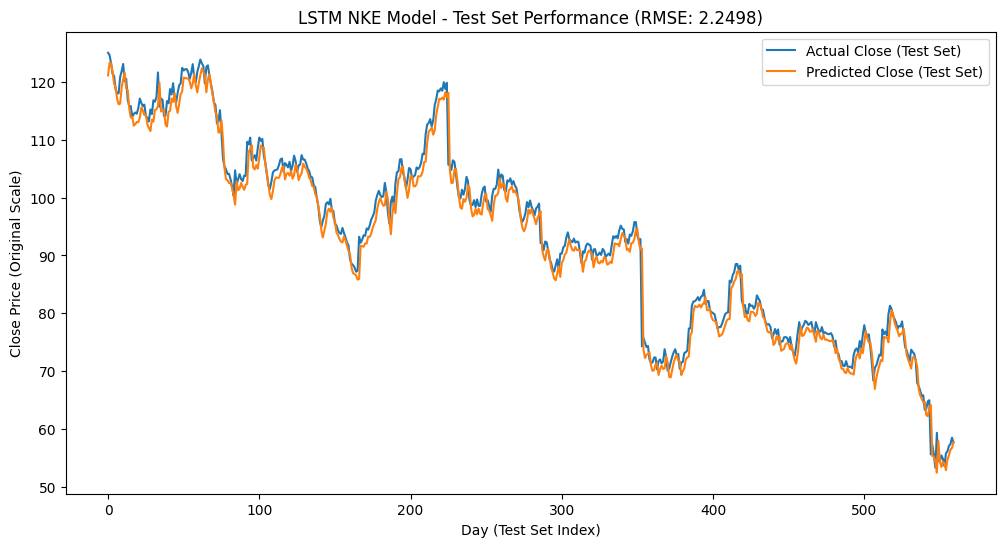

In [20]:
if 'actual_test_inv' in locals() and 'test_predictions_inv' in locals():
    plt.figure(figsize=(12, 6))
    plt.plot(actual_test_inv, label='Actual Close (Test Set)')
    plt.plot(test_predictions_inv, label='Predicted Close (Test Set)')
    plt.xlabel('Day (Test Set Index)')
    plt.ylabel('Close Price (Original Scale)')
    plt.title(f'LSTM {ticker} Model - Test Set Performance (RMSE: {final_rmse:.4f})')
    plt.legend()
    plt.show()
else:
    print("Inverse transformed predictions/actuals not found. Cannot plot.")

## 20. Prepare Data for MLP

In [21]:
# Reshape X_train and X_test for MLP: from (num_samples, lookback, 1) to (num_samples, lookback)
X_train_mlp = X_train.reshape(X_train.shape[0], lookback)
X_test_mlp = X_test.reshape(X_test.shape[0], lookback)

# y_train and y_test tensors are already shape (num_samples, 1) which is suitable for the target.

# We will use the original 'scaler' object (fitted earlier) for inverse transform in Cell 9.

#Create new Datasets and DataLoaders for MLP data

# Use the reshaped X tensors and original y tensors (ensure they are on the correct device)
mlp_train_dataset = TimeSeriesDataset(X_train_mlp.to(device), y_train.to(device))
mlp_test_dataset = TimeSeriesDataset(X_test_mlp.to(device), y_test.to(device))

# Create new DataLoaders
# Ensure batch_size is defined from an earlier cell
mlp_train_loader = DataLoader(mlp_train_dataset, batch_size=batch_size, shuffle=True)
mlp_test_loader = DataLoader(mlp_test_dataset, batch_size=batch_size, shuffle=False)

## 21. Define MLP Model

In [22]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        # Input layer: Takes 'lookback' number of features
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU() # Activation function
        # Second hidden layer
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        # Output layer: Predicts a single value (next day's close)
        self.output_layer = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Forward pass logic
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x


mlp_input_size = lookback
mlp_hidden1 = 32
mlp_hidden2 = 16
mlp_output_size = 1

mlp_model = MLP(mlp_input_size, mlp_hidden1, mlp_hidden2, mlp_output_size)
mlp_model.to(device)

MLP(
  (layer1): Linear(in_features=7, out_features=32, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

## 22. MLP Model Training

MLP Training Epoch: 1/10, Loss: 0.02658
MLP Training Epoch: 2/10, Loss: 0.00024
MLP Training Epoch: 3/10, Loss: 0.00021
MLP Training Epoch: 4/10, Loss: 0.00018
MLP Training Epoch: 5/10, Loss: 0.00016
MLP Training Epoch: 6/10, Loss: 0.00015
MLP Training Epoch: 7/10, Loss: 0.00014
MLP Training Epoch: 8/10, Loss: 0.00014
MLP Training Epoch: 9/10, Loss: 0.00013
MLP Training Epoch: 10/10, Loss: 0.00014


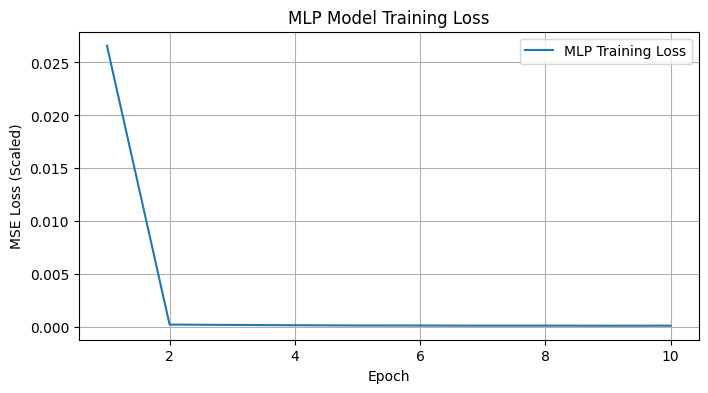

In [23]:


# Define Training Hyperparameters
mlp_learning_rate = 0.001 # Standard learning rate for Adam
num_mlp_epochs = 10      # Train for same duration as LSTM

loss_function_mlp = nn.MSELoss() # Mean Squared Error loss
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=mlp_learning_rate) # Adam optimizer

mlp_train_losses = [] # Store training loss per epoch

# Training Loop
for epoch in range(num_mlp_epochs):
    mlp_model.train() # Set model to training mode
    running_loss = 0.0
    for batch_index, batch in enumerate(mlp_train_loader):
        x_batch, y_batch = batch[0], batch[1] # Data already on device

        # Forward pass
        output = mlp_model(x_batch)
        loss = loss_function_mlp(output, y_batch)
        running_loss += loss.item()

        # Backward pass and optimize
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()

    # Log average loss for the epoch
    avg_loss_epoch = running_loss / len(mlp_train_loader)
    mlp_train_losses.append(avg_loss_epoch)
    print(f'MLP Training Epoch: {epoch + 1}/{num_mlp_epochs}, Loss: {avg_loss_epoch:.5f}')

# Plot MLP training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_mlp_epochs + 1), mlp_train_losses, label='MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Scaled)')
plt.title('MLP Model Training Loss')
plt.legend()
plt.grid(True)
plt.show()

## 23. MLP Evaluation

In [24]:
mlp_model.eval() # Set model to evaluation mode
mlp_test_predictions_scaled = []
mlp_actual_test_scaled = []

with torch.no_grad(): # Turn off gradients for inference
    for batch_index, batch in enumerate(mlp_test_loader):
        x_batch, y_batch = batch[0], batch[1]
        output = mlp_model(x_batch)
        mlp_test_predictions_scaled.extend(output.cpu().numpy().flatten())
        mlp_actual_test_scaled.extend(y_batch.cpu().numpy().flatten())

# Convert lists to numpy arrays
mlp_test_predictions_scaled = np.array(mlp_test_predictions_scaled)
mlp_actual_test_scaled = np.array(mlp_actual_test_scaled)

print(f"MLP Predictions generated for {len(mlp_test_predictions_scaled)} test samples.")


# Create dummy arrays matching the shape the original scaler expects (n_samples, n_features)
# n_features = lookback + 1
pred_dummies_mlp = np.zeros((len(mlp_test_predictions_scaled), lookback + 1))
pred_dummies_mlp[:, 0] = mlp_test_predictions_scaled # Put predictions in the first column
# Inverse transform using the original scaler and get only the first column
mlp_test_predictions_inv = scaler.inverse_transform(pred_dummies_mlp)[:, 0] # Use original 'scaler'

actual_dummies_mlp = np.zeros((len(mlp_actual_test_scaled), lookback + 1))
actual_dummies_mlp[:, 0] = mlp_actual_test_scaled # Put actuals in the first column
# Inverse transform using the original scaler and get only the first column
mlp_actual_test_inv = scaler.inverse_transform(actual_dummies_mlp)[:, 0] # Use original 'scaler'

# Calculate Final Root Mean Squared Error (RMSE) for MLP
mlp_final_rmse = math.sqrt(mean_squared_error(mlp_actual_test_inv, mlp_test_predictions_inv))

MLP Predictions generated for 560 test samples.


## 24. MLP Plot


--- Plotting MLP Final Test Set Results (Original Scale) ---


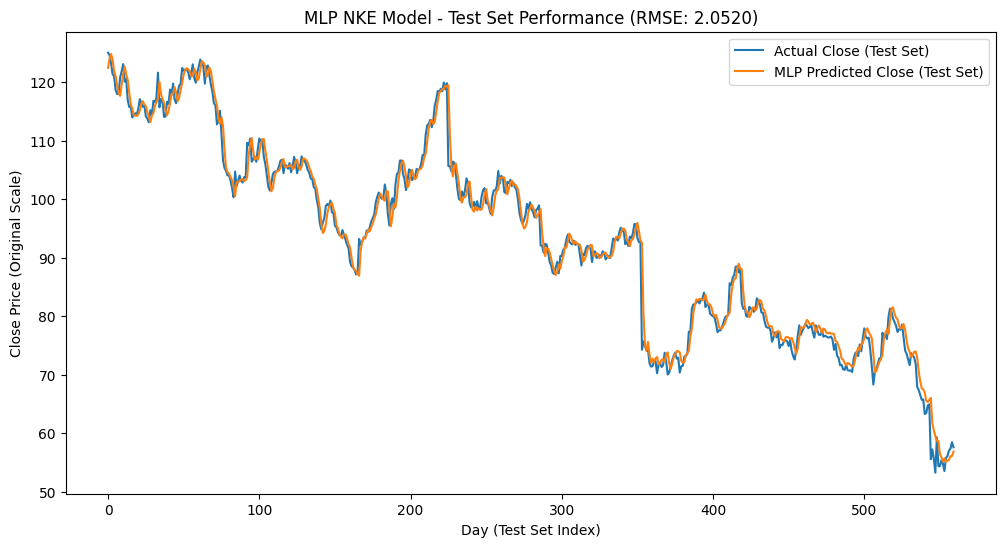

In [25]:
if 'mlp_actual_test_inv' in locals() and 'mlp_test_predictions_inv' in locals() and 'mlp_final_rmse' in locals() and mlp_final_rmse is not None:
    print("\n--- Plotting MLP Final Test Set Results (Original Scale) ---")
    plt.figure(figsize=(12, 6))
    plt.plot(mlp_actual_test_inv, label='Actual Close (Test Set)')
    plt.plot(mlp_test_predictions_inv, label='MLP Predicted Close (Test Set)')
    plt.xlabel('Day (Test Set Index)')
    plt.ylabel('Close Price (Original Scale)')
    plt.title(f'MLP {ticker} Model - Test Set Performance (RMSE: {mlp_final_rmse:.4f})')
    plt.legend()
    plt.show()
else:
    print("Inverse transformed MLP predictions/actuals or final MLP RMSE not found from Cell 9. Cannot plot.")